# Generación de Dataset Sintético para Retail en Perú

Este notebook genera un dataset de transacciones simuladas para tiendas de conveniencia en Perú (tipo Tambo, Oxxo, etc.).

In [1]:
import pandas as pd
import numpy as np
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Configuración para reproducibilidad
np.random.seed(42)
random.seed(42)

In [2]:
# --- DEFINICIÓN DE DATOS ---

num_registros = 10000

# Datos Geográficos y de Tienda
ciudades = ['Lima', 'Piura', 'Arequipa', 'Cusco', 'Trujillo', 'Huancayo']
zonas = ['Residencial', 'Comercial', 'Mixta']

# Datos de Cliente
generos = ['M', 'F', 'Otro']
nse = ['Alto', 'Medio', 'Bajo']

# Datos de Transacción
medios_pago = ['Efectivo', 'Tarjeta', 'Yape/Plin']
climas = ['Soleado', 'Lluvioso', 'Nublado']

# Productos y Categorías
productos = {
    'Bebidas': ['Gaseosa 500ml', 'Agua Mineral', 'Energizante', 'Jugo Caja'],
    'Snacks': ['Papas Fritas', 'Galletas', 'Chizitos', 'Frutos Secos'],
    'Comidas preparadas': ['Sandwich Pollo', 'Empanada', 'Hot Dog', 'Hamburguesa'],
    'Alcohol': ['Cerveza Lata', 'Vino Tinto', 'Ron Botella', 'Pisco'],
    'Aseo personal': ['Jabón', 'Shampoo Sachet', 'Pasta Dental', 'Papel Higiénico'],
    'Mascotas': ['Comida Perro', 'Comida Gato', 'Premio Mascota'],
    'Farmacia': ['Paracetamol', 'Ibuprofeno', 'Curitas', 'Alcohol Medicinal']
}
categorias = list(productos.keys())

# Promociones
tipos_promocion = ['2x1', 'Descuento %', 'Combo', 'Ninguno']

# Comportamiento
motivos = ['Compra rápida', 'Reposición', 'Antojo', 'Almuerzo', 'Emergencia']
companias = ['Solo', 'Con amigos', 'Con familia']

In [3]:
# --- GENERACIÓN DE DATOS ---

data = []

# Generar un pool de clientes para simular recurrencia
num_clientes_unicos = 4000
clientes_pool = []
for i in range(num_clientes_unicos):
    clientes_pool.append({
        'customer_id': f'CUST_{i:05d}',
        'edad': random.randint(18, 70),
        'genero': np.random.choice(generos, p=[0.48, 0.48, 0.04]),
        'nivel_socioeconomico': np.random.choice(nse, p=[0.2, 0.5, 0.3])
    })

start_date = datetime(2023, 1, 1)

for i in range(num_registros):
    # Seleccionar cliente
    cliente = random.choice(clientes_pool)
    
    # Fecha y Hora
    dias_offset = random.randint(0, 365)
    fecha = start_date + timedelta(days=dias_offset)
    hora_int = random.randint(7, 23)
    minuto_int = random.randint(0, 59)
    hora_str = f"{hora_int:02d}:{minuto_int:02d}"
    
    # Tienda
    ubicacion = np.random.choice(ciudades, p=[0.5, 0.1, 0.1, 0.1, 0.1, 0.1]) # Más peso a Lima
    zona = random.choice(zonas)
    
    # Producto
    cat = random.choice(categorias)
    prod = random.choice(productos[cat])
    cantidad = random.randint(1, 5)
    precio_base = round(random.uniform(2.0, 50.0), 2)
    
    # Ajuste de precio por categoría (simple)
    if cat == 'Alcohol': precio_base += 10
    if cat == 'Comidas preparadas': precio_base += 5
    
    subtotal = cantidad * precio_base
    
    # Promoción
    usa_promo = np.random.choice(['Sí', 'No'], p=[0.3, 0.7])
    tipo_promo = 'Ninguno'
    ticket_total = subtotal
    
    if usa_promo == 'Sí':
        tipo_promo = random.choice(['2x1', 'Descuento %', 'Combo'])
        if tipo_promo == '2x1' and cantidad >= 2:
            ticket_total = subtotal - (precio_base * (cantidad // 2))
        elif tipo_promo == 'Descuento %':
            ticket_total = subtotal * 0.85 # 15% dscto
        elif tipo_promo == 'Combo':
            ticket_total = subtotal * 0.90
            
    ticket_total = round(ticket_total, 2)
    
    # Transacción
    row = {
        'transaction_id': f'TRX_{i:06d}',
        'customer_id': cliente['customer_id'],
        'edad': cliente['edad'],
        'genero': cliente['genero'],
        'nivel_socioeconomico': cliente['nivel_socioeconomico'],
        'ubicacion_tienda': ubicacion,
        'tipo_zona': zona,
        'fecha': fecha.strftime('%Y-%m-%d'),
        'dia_semana': fecha.strftime('%A'), # En inglés por defecto, se puede mapear luego
        'hora': hora_str,
        'clima': random.choice(climas),
        'medio_pago': random.choice(medios_pago),
        'categoria_producto': cat,
        'producto_especifico': prod,
        'cantidad': cantidad,
        'precio_unitario': round(precio_base, 2),
        'subtotal': round(subtotal, 2),
        'uso_promocion': usa_promo,
        'tipo_promocion': tipo_promo,
        'ticket_total': ticket_total,
        'motivo_visita': random.choice(motivos),
        'compania': random.choice(companias),
        'tiempo_en_tienda_minutos': random.randint(1, 20)
    }
    data.append(row)

df = pd.DataFrame(data)

# Traducir días de la semana si es necesario
dias_map = {
    'Monday': 'Lunes', 'Tuesday': 'Martes', 'Wednesday': 'Miércoles', 
    'Thursday': 'Jueves', 'Friday': 'Viernes', 'Saturday': 'Sábado', 'Sunday': 'Domingo'
}
df['dia_semana'] = df['dia_semana'].map(dias_map)

In [4]:
# --- VARIABLES DERIVADAS ---

# 1. Calcular frecuencia de compra y ticket promedio por cliente
cliente_stats = df.groupby('customer_id').agg(
    frecuencia_compra=('transaction_id', 'count'),
    ticket_promedio=('ticket_total', 'mean')
).reset_index()

# 2. Asignar es_cliente_frecuente (Ejemplo: más de 3 compras en el dataset)
# Nota: En un dataset de 10k registros y 4k clientes, el promedio es 2.5 compras/cliente
umbral_frecuente = 3
cliente_stats['es_cliente_frecuente'] = np.where(cliente_stats['frecuencia_compra'] >= umbral_frecuente, 'Sí', 'No')

# 3. Asignar nivel_fidelizacion
# Lógica simple: 
# Alto: Frecuente Y Ticket Alto (> promedio global)
# Medio: Frecuente O Ticket Alto
# Bajo: Ni frecuente ni ticket alto

promedio_global_ticket = df['ticket_total'].mean()

def calcular_fidelizacion(row):
    es_frec = row['frecuencia_compra'] >= umbral_frecuente
    ticket_alto = row['ticket_promedio'] > promedio_global_ticket
    
    if es_frec and ticket_alto:
        return 'Alto'
    elif es_frec or ticket_alto:
        return 'Medio'
    else:
        return 'Bajo'

cliente_stats['nivel_fidelizacion'] = cliente_stats.apply(calcular_fidelizacion, axis=1)

# Unir las variables derivadas al dataframe principal
df = df.merge(cliente_stats[['customer_id', 'es_cliente_frecuente', 'nivel_fidelizacion']], on='customer_id', how='left')

In [5]:
# --- RESULTADOS ---

# 3. Mostrar las primeras 10 filas
print("Primeras 10 filas del dataset:")
display(df.head(10))

# Información general
print("\nInformación del DataFrame:")
df.info()

Primeras 10 filas del dataset:


,transaction_id,customer_id,edad,genero,nivel_socioeconomico,ubicacion_tienda,tipo_zona,fecha,dia_semana,hora,...,precio_unitario,subtotal,uso_promocion,tipo_promocion,ticket_total,motivo_visita,compania,tiempo_en_tienda_minutos,es_cliente_frecuente,nivel_fidelizacion
0,TRX_000000,CUST_02752,47,M,Alto,Cusco,Residencial,2023-03-10,Viernes,17:07,...,24.92,49.84,No,Ninguno,49.84,Almuerzo,Con amigos,20,Sí,Medio
1,TRX_000001,CUST_00564,35,M,Medio,Lima,Residencial,2023-10-22,Domingo,19:27,...,20.01,100.05,No,Ninguno,100.05,Reposición,Con amigos,15,Sí,Alto
2,TRX_000002,CUST_02537,34,Otro,Medio,Piura,Comercial,2023-01-28,Sábado,18:00,...,48.26,193.04,No,Ninguno,193.04,Almuerzo,Con amigos,16,Sí,Alto
3,TRX_000003,CUST_01702,38,F,Bajo,Cusco,Residencial,2023-12-30,Sábado,21:31,...,16.02,32.04,Sí,Descuento %,27.23,Antojo,Solo,15,Sí,Medio
4,TRX_000004,CUST_02316,25,F,Bajo,Arequipa,Mixta,2023-09-11,Lunes,23:07,...,41.52,207.60,Sí,Descuento %,176.46,Almuerzo,Con familia,7,Sí,Alto
5,TRX_000005,CUST_01741,63,M,Bajo,Trujillo,Residencial,2023-02-22,Miércoles,14:19,...,53.39,160.17,No,Ninguno,160.17,Compra rápida,Solo,7,Sí,Alto
6,TRX_000006,CUST_03320,37,F,Bajo,Arequipa,Mixta,2023-10-29,Domingo,18:55,...,31.58,63.16,Sí,2x1,31.58,Emergencia,Con amigos,18,Sí,Alto
7,TRX_000007,CUST_01151,55,F,Medio,Arequipa,Mixta,2023-11-02,Jueves,12:20,...,19.83,99.15,No,Ninguno,99.15,Compra rápida,Solo,14,No,Medio
8,TRX_000008,CUST_03763,56,F,Medio,Lima,Mixta,2023-01-31,Martes,15:55,...,9.02,18.04,No,Ninguno,18.04,Almuerzo,Con amigos,5,No,Bajo
9,TRX_000009,CUST_02365,65,M,Alto,Lima,Comercial,2023-11-20,Lunes,15:40,...,42.41,42.41,No,Ninguno,42.41,Emergencia,Con familia,9,No,Bajo



Información del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   transaction_id            10000 non-null  object 
 1   customer_id               10000 non-null  object 
 2   edad                      10000 non-null  int64  
 3   genero                    10000 non-null  object 
 4   nivel_socioeconomico      10000 non-null  object 
 5   ubicacion_tienda          10000 non-null  object 
 6   tipo_zona                 10000 non-null  object 
 7   fecha                     10000 non-null  object 
 8   dia_semana                10000 non-null  object 
 9   hora                      10000 non-null  object 
 10  clima                     10000 non-null  object 
 11  medio_pago                10000 non-null  object 
 12  categoria_producto        10000 non-null  object 
 13  producto_especifico       10000 no

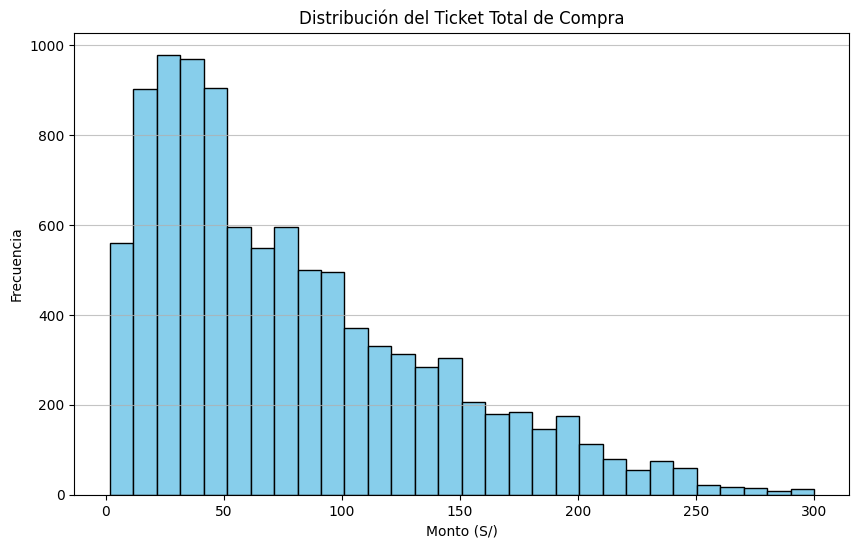

In [6]:
# 4. Gráfico de distribución de ticket_total
plt.figure(figsize=(10, 6))
plt.hist(df['ticket_total'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribución del Ticket Total de Compra')
plt.xlabel('Monto (S/)')
plt.ylabel('Frecuencia')
plt.grid(axis='y', alpha=0.75)
plt.show()

In [7]:
# 5. Exportar a CSV
df.to_csv('transacciones_tienda_conveniencia.csv', index=False)
print("Dataset exportado exitosamente a 'transacciones_tienda_conveniencia.csv'")

Dataset exportado exitosamente a 'transacciones_tienda_conveniencia.csv'
